# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

1 [Подготовка данных](#1)

- 1.1 [Просмотр файлов](#1.1)
- 1.2 [Проверка правильности расчета эффективности](#1.2)
- 1.3 [Анализ признаков, недоступных в тестовой выборке](#1.3)
- 1.4 [Предобработка данных](#1.4)

2 [Анализ данных](#2)
* 2.1 [Изменение концентрации металлов на различных этапах очистки](#2.1)
* 2.2 [Cравнение распределений гранул сырья в выборках](#2.2)
* 2.3 [Исследование концентраций металлов на всех стадиях](#2.3)

3 [Модель](#3)

* [Метрика качества](#3.2_1)
* [Разбиение выборки](#3.11)

3.1 [Первая модель - для прогноза полного цикла обогощения от золотосодержащей руды до финального концентрата](#3.1)
    
    Этапы обучения:
   - [Отбор лучших моделей для обучения](#3.12)
   - [Отбор признаков по важности случайного леса и линейные наименьшие квадраты с регуляризацией l2](#3.13)
   - [Улучшение модели методом стандартизации данных StandardScaler()](#3.14)
   - [Улучшение модели путем подбора гиперпараметров RandomForestRegressor](#3.15) 
   - [Оценка качества работы модели на проверочных данных](#3.16)
    
    
3.2 [Вторая модель - прогнозирует производство чернового концентрата на этапе флотации](#3.2)
   
    Этапы обучения:
   - [Разбиение выборки](#3.21)
   - [Стандартизация данных](#3.22)
   - [Обучение базовой модели (RF)](#3.23) 
   - [Анализ показателей важности признаков RandomForestRegressor](#3.24)
   - [Отбор признаков. Метод главных компонент (PCA)](#3.25) 
   - [Обучение базовой модели после применения к данным метода главных компонент ( RF + PCA)](#3.26)
   - [Обширный поиск гиперпараметров с RandomizedSearchCV](#3.27) 
   - [Оптимизация гиперпараметров с GridSearchCV Hyperparameter Tuning для модели (RF + PCA + HT)](#3.28)
   - [Оценка качества работы модели на проверочных данных](#3.29) 
    
    
4 [расчет метрики "Итоговый sMAPE"](#4)

5 [Проверка моделей на адекватность](#5)

## Комментарий ревьюера
<span style="color:green">Приступим к работе.</span>

In [1]:
import pandas as pd
import numpy as np
import random
import itertools
from scipy import stats as st
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     RandomizedSearchCV, 
                                     GridSearchCV)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
pd.set_option('display.max_columns', 90) # настройка отображения таблиц
pd.set_option('display.max_rows', 90) # настройка отображения таблиц

# 1. Подготовка данных<a id="1"></a>

## 1.1 Просмотр файлов<a id="1.1"></a>

In [2]:
dataset = ['./datasets/gold_recovery_train.csv', 
           './datasets/gold_recovery_test.csv', 
           './datasets/gold_recovery_full.csv']

# словарь с парами 'имя_таблицы:DataFrame' для удобства итерации по датафреймам. позже вынести в глобальные
gold_data = {}

# Функция читате файл csv
def read_files(name_df, file): 
    try:
        name_df = pd.read_csv(file)
    except:
        print('Не удалось прочитать', file, 'проверьте расположение файла')
    return name_df
# Функция разбирает пути из списка, выделяет из каждого имя файла и записывает в индекс словаря: имя 
# а результат работы функции read_files в значение 
def read_files_get_list(files):
    for file in files:
        only_file_name = file.split("/")[-1][0:-4]
        gold_data[only_file_name] = read_files(only_file_name, file)

read_files_get_list(dataset)

In [3]:
#data.isnull().sum()/len(data)*100
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [4]:
# проверка датафреймов
def chek_df(data):
    print('строк', data.shape[0])
    print()
    print('пропуски')
    print(missing_data(data))     #print(data.isnull().sum())
    display(data.describe().T)

In [5]:
# Общая информация
for name, data in gold_data.items():
    print('=='*5, 'Info по' , name, '=='*5)
    data.info()
    print('')
    chek_df(data)
    print('')

========== Info по gold_recovery_train ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol     

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,16788.0,4.716907,2.096718e+00,0.000000e+00,3.971262,4.869346,5.821176,1.600195e+01
final.output.concentrate_pb,16788.0,9.113559,3.389495e+00,0.000000e+00,8.825748,10.065316,11.054809,1.703190e+01
final.output.concentrate_sol,16490.0,8.301123,3.825760e+00,0.000000e+00,6.939185,8.557228,10.289741,1.812485e+01
final.output.concentrate_au,16789.0,39.467217,1.391723e+01,0.000000e+00,42.055722,44.498874,45.976222,5.361137e+01
final.output.recovery,15339.0,67.213166,1.196045e+01,0.000000e+00,62.625685,67.644601,72.824595,1.000000e+02
final.output.tail_ag,16794.0,8.757048,3.634103e+00,0.000000e+00,7.610544,9.220393,10.971110,1.955215e+01
final.output.tail_pb,16677.0,2.360327,1.215576e+00,0.000000e+00,1.641604,2.453690,3.192404,6.086532e+00
final.output.tail_sol,16715.0,9.303932,4.263208e+00,0.000000e+00,7.870275,10.021968,11.648573,2.231773e+01
final.output.tail_au,16794.0,2.687512,1.272757e+00,0.000000e+00,2.172953,2.781132,3.416936,9.789625e+00
primary_cleaner.input.sulfate,15553.0,129.479789,4.538693e+01,2.567664e-06,103.064021,131.783108,159.539839,2.519999e+02



========== Info по gold_recovery_test ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229
primary_cleaner.state.floatbank8_c_air,5840.0,1468.495216,309.980748,0.000000,1437.050321,1546.160672,1600.785573,1715.053773
primary_cleaner.state.floatbank8_c_level,5840.0,-509.741212,62.671873,-799.995127,-501.300441,-500.079537,-499.009545,-150.937035



========== Info по gold_recovery_full ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol     

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,22627.0,4.781559e+00,2.030128e+00,0.000000e+00,4.018525,4.953729,5.862593,1.600195e+01
final.output.concentrate_pb,22629.0,9.095308e+00,3.230797e+00,0.000000e+00,8.750171,9.914519,10.929839,1.703190e+01
final.output.concentrate_sol,22331.0,8.640317e+00,3.785035e+00,0.000000e+00,7.116799,8.908792,10.705824,1.961572e+01
final.output.concentrate_au,22630.0,4.000117e+01,1.339806e+01,0.000000e+00,42.383721,44.653436,46.111999,5.361137e+01
final.output.recovery,20753.0,6.744749e+01,1.161603e+01,0.000000e+00,63.282393,68.322258,72.950836,1.000000e+02
final.output.tail_ag,22633.0,8.923690e+00,3.517917e+00,0.000000e+00,7.684016,9.484369,11.084557,1.955215e+01
final.output.tail_pb,22516.0,2.488252e+00,1.189407e+00,0.000000e+00,1.805376,2.653001,3.287790,6.086532e+00
final.output.tail_sol,22445.0,9.523632e+00,4.079739e+00,0.000000e+00,8.143576,10.212998,11.860824,2.286175e+01
final.output.tail_au,22635.0,2.827459e+00,1.262834e+00,0.000000e+00,2.303108,2.913794,3.555077,9.789625e+00
primary_cleaner.input.sulfate,21107.0,1.402777e+02,4.991900e+01,2.567664e-06,110.177081,141.330501,174.049914,2.744096e+02


In [6]:
# Смотрим данные
for name, data in gold_data.items():
    print('=='*7, 'Таблица', name, '=='*7)
    display(data.head(5).T)

============== Таблица gold_recovery_train ==============


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.0554,6.02937,6.05593,6.04798,6.1486
final.output.concentrate_pb,9.88965,9.96894,10.214,9.97702,10.1425
final.output.concentrate_sol,5.50732,5.25778,5.38376,4.85863,4.93942
final.output.concentrate_au,42.192,42.7016,42.6575,42.6898,42.7741
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.927
final.output.tail_ag,10.412,10.4627,10.507,10.4228,10.3603
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257
final.output.tail_au,2.14315,2.22493,2.25789,2.14685,2.05529


============== Таблица gold_recovery_test ==============


,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.801,215.392,215.26,215.336,199.099
primary_cleaner.input.depressant,14.9931,14.9875,12.8849,12.0068,10.6825
primary_cleaner.input.feed_size,8.08,8.08,7.78667,7.64,7.53
primary_cleaner.input.xanthate,1.00502,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.98,1398.78,1398.49,1399.62,1401.27
primary_cleaner.state.floatbank8_a_level,-500.226,-500.057,-500.868,-498.864,-500.808
primary_cleaner.state.floatbank8_b_air,1399.14,1398.06,1398.86,1397.44,1398.13
primary_cleaner.state.floatbank8_b_level,-499.92,-499.778,-499.765,-499.211,-499.505
primary_cleaner.state.floatbank8_c_air,1400.1,1396.15,1398.08,1400.13,1402.17


============== Таблица gold_recovery_full ==============


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.0554,6.02937,6.05593,6.04798,6.1486
final.output.concentrate_pb,9.88965,9.96894,10.214,9.97702,10.1425
final.output.concentrate_sol,5.50732,5.25778,5.38376,4.85863,4.93942
final.output.concentrate_au,42.192,42.7016,42.6575,42.6898,42.7741
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.927
final.output.tail_ag,10.412,10.4627,10.507,10.4228,10.3603
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257
final.output.tail_au,2.14315,2.22493,2.25789,2.14685,2.05529


In [7]:
globals().update(gold_data) # Передаем названия и объекты таблиц в глобальное пространство имен

In [8]:
gold_data.keys()

dict_keys(['gold_recovery_train', 'gold_recovery_test', 'gold_recovery_full'])

## 1.2 Проверка правильности расчета эффективности<a id="1.2"></a>

Расчет эффективности производится по формуле

`recovery = ((output * (input - tail)) / (input * (output - tail))) * 100`

### Признаки для расчета эффективности

Этап rougher

    rougher.input.feed_au - вход
    rougher.output.concentrate_au - выход 
    rougher.output.tail_au - отвал

    rougher.output.recovery - эффективность этапа


Этап cleaner

* primary
		rougher.output.concentrate_au - вход
		primary_cleaner.output.concentrate_au - выход 
		primary_cleaner.output.tail_au - отвал

* secondary
		primary_cleaner.output.concentrate_au - вход
		final.output.concentrate_au - выход 
		secondary_cleaner.output.tail_au - отвал

	
    final.output.tail_au - отвал общий
	final.output.recovery - эффективность общая 

### Копируем нужные для расчета данные в отдельный датафрейм

In [9]:
column_list = [
    'rougher.output.recovery', 
    'rougher.input.feed_au', 
    'rougher.output.concentrate_au', 
    'rougher.output.tail_au'
]
gold_compare = gold_recovery_train[column_list].copy(deep=True)

In [10]:
chek_df(gold_compare)

строк 16860

пропуски
                               Total    Percent
rougher.output.recovery         2573  15.260973
rougher.output.tail_au          2249  13.339265
rougher.input.feed_au             83   0.492289
rougher.output.concentrate_au     82   0.486358


,count,mean,std,min,25%,50%,75%,max
rougher.output.recovery,14287.0,82.394201,15.096808,0.000000,79.818372,85.235997,90.131691,100.000000
rougher.input.feed_au,16777.0,7.170717,3.002113,0.000000,6.203083,7.443530,8.965193,14.093363
rougher.output.concentrate_au,16778.0,17.401541,6.921875,0.000000,17.443663,19.644663,21.224486,28.522811
rougher.output.tail_au,14611.0,1.763930,0.731518,0.020676,1.311610,1.747907,2.190839,9.688980


### Удаляем пропуски

In [11]:
gold_compare = gold_compare.dropna()

In [12]:
print('Пропуски', '\n', missing_data(gold_compare))

Пропуски 
                                Total  Percent
rougher.output.tail_au             0      0.0
rougher.output.concentrate_au      0      0.0
rougher.input.feed_au              0      0.0
rougher.output.recovery            0      0.0


### Считаем эффективность

In [13]:
def au_recovery(input_au, output_au, tail_au):
    ''' Возвращает serias с рассчитаной эффективностью обогащения'''
    recovery = ((output_au * (input_au - tail_au)) / (input_au * (output_au - tail_au))) * 100
    return recovery
    

def properties_stage(rougher_recovery, calc_recovery):
    print('Расчет эффективности',)
    print('Среднее в rougher.output.recovery',rougher_recovery.mean())
    print('Расчетное среднее', calc_recovery.mean())
    print('MAE:', mean_absolute_error(rougher_recovery, calc_recovery))

In [14]:
calc_rougher_recovery = au_recovery(
    gold_compare['rougher.input.feed_au'], 
    gold_compare['rougher.output.concentrate_au'], 
    gold_compare['rougher.output.tail_au']
)

In [15]:
properties_stage(gold_compare['rougher.output.recovery'], calc_rougher_recovery)

Расчет эффективности
Среднее в rougher.output.recovery 82.39420120842004
Расчетное среднее 82.39420120842004
MAE: 9.444891926100695e-15


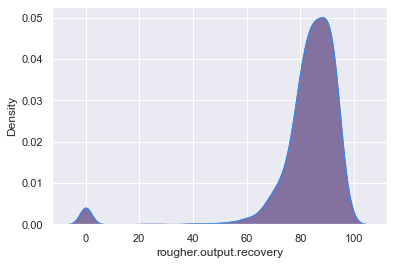

In [16]:
sns.kdeplot(gold_compare['rougher.output.recovery'], shade=True, color="r", label="эффективность из данных", alpha=.9)
sns.kdeplot(calc_rougher_recovery, shade=True, color="dodgerblue", label="эффективность расчетная", alpha=.4)
plt.show()

## Вывод 
MAE около нуля. Расчеты верны

## 1.3 Анализ признаков, недоступных в тестовой выборке<a id="1.3"></a>

In [17]:
# функция выводит разность столбцов датасетов 1 ко 2 и 2 к 1
def difference_list(lst1, lst2):
    difference1to2=[]
    difference2to1=[]
    for el in lst1:
        if el not in lst2:
            difference1to2.append(el)
    for el in lst2:
        if el not in lst1:
            difference2to1.append(el)
    return difference1to2, difference2to1

In [18]:
diff = difference_list(gold_recovery_train.columns, gold_recovery_test.columns)[0]

In [19]:
display(diff)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

## Вывод 
В тестовой выборке недоступны целевые признаки связанные с результатами обогащения по разным параметрам и расчетные характеристики флотации.

## 1.4 Предобработка данных<a id="1.4"></a>

In [20]:
# lower = Отбрасываются выбросы до этого числа
def drop_ejection(df, columns, lower = .025, upper = .975):
    print('*** режим отладки. см. def drop_ejection ***') # отладка
    for column in columns:
        print(df.shape, column, 'lower: {:.3f}, upper: {:.3f}'                 # отладка
              .format(df[column].quantile(lower), df[column].quantile(upper))) # отладка
        df = df.drop(
            # (df[df[column] <= lower].index) #выбор 1, отладка   такой отброс Показывает лучший результат
            (df[df[column] < df[column].quantile(lower)].index) #выбор 1, отладка 
        )
        df = df.drop(
            #(df[df[column] < lower].index) #выбор 2, отладка
            (df[df[column] > df[column].quantile(upper)].index) #выбор 2, отладка        
        )
    return df

In [21]:
# Входящие данные

print('gold_recovery_test', gold_recovery_test.shape)
print('gold_recovery_train', gold_recovery_train.shape)
print('gold_recovery_full', gold_recovery_full.shape)

gold_recovery_test (5856, 53)
gold_recovery_train (16860, 87)
gold_recovery_full (22716, 87)


Попытаемся заполнить недостающие данные в датафреймах. gold_recovery_train из gold_recovery_full, gold_recovery_full из gold_recovery_train. Эти фреймы одинаковой размерности, а данные индексируются ежечасно.

In [22]:
na_full = gold_recovery_full.isnull().sum().sum()
na_train = gold_recovery_train.isnull().sum().sum()

gold_recovery_train = gold_recovery_train.fillna(gold_recovery_full)
gold_recovery_full = gold_recovery_full.fillna(gold_recovery_train)

print('обработано пропусков в full {:0} из {:0}'.format(na_full - gold_recovery_full.isnull().sum().sum(), na_full))
print('обработано пропусков в full {:0} из {:0}'.format (na_train - gold_recovery_train.isnull().sum().sum(), na_train))

обработано пропусков в full 11622 из 36587
обработано пропусков в full 18022 из 30320


Посмотрим на целевые признаки.

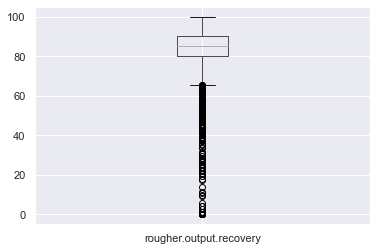

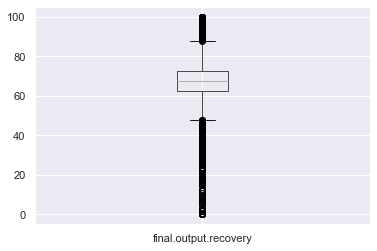

In [23]:
gold_recovery_train.boxplot(column= 'rougher.output.recovery')
plt.show()
gold_recovery_train.boxplot(column= 'final.output.recovery')
plt.show()

Обработаем нижние выбросы 

In [24]:
gold_recovery_train = drop_ejection(
    gold_recovery_train, ['rougher.output.recovery', 'final.output.recovery'], lower = .02, upper = .999)

*** режим отладки. см. def drop_ejection ***
(16860, 87) rougher.output.recovery lower: 0.000, upper: 99.309
(16844, 87) final.output.recovery lower: 39.270, upper: 100.000


In [25]:
# отдельная выборка для анализа данных
df_for_analysis = gold_recovery_train.copy()

### Получаем тестовую выборку

In [26]:
# восстанавливаем недостающие признаки gold_recovery_test из выборки gold_recovery_full по значению 'date'
gold_recovery_test = gold_recovery_full.loc[gold_recovery_full['date'].isin(gold_recovery_test['date'])]

In [27]:
diff.remove('rougher.output.recovery')
diff.remove('final.output.recovery')

In [28]:
gold_recovery_train = gold_recovery_train.drop(diff, axis=1)
gold_recovery_test = gold_recovery_test.drop(diff, axis=1)


In [29]:
# отбрасываем столбец 'date'
gold_recovery_train = gold_recovery_train.drop(['date'], axis=1)
gold_recovery_test = gold_recovery_test.drop(['date'], axis=1)

# Удаляем пропуски в данных
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_test = gold_recovery_test.dropna() 
df_for_analysis = df_for_analysis.dropna() 

# Осталось данных
print(gold_recovery_test.shape)
print(gold_recovery_train.shape)

(5742, 54)
(15134, 54)


# 2. Анализ данных<a id="2"></a>

## 2.1 Изменение концентрации металлов на различных этапах очистки<a id="2.1"></a>

In [30]:
metals = pd.DataFrame(
    [['gold_ore', df_for_analysis['rougher.input.feed_ag'].mean(), df_for_analysis['rougher.input.feed_pb'].mean(), df_for_analysis['rougher.input.feed_au'].mean()],
['rougher', df_for_analysis['rougher.output.concentrate_ag'].mean(), df_for_analysis['rougher.output.concentrate_pb'].mean(), df_for_analysis['rougher.output.concentrate_au'].mean()],
['primary_cleaner', df_for_analysis['primary_cleaner.output.concentrate_ag'].mean(), df_for_analysis['primary_cleaner.output.concentrate_pb'].mean(), df_for_analysis['primary_cleaner.output.concentrate_au'].mean()],
['secondary_cleaner', df_for_analysis['final.output.concentrate_ag'].mean(), df_for_analysis['final.output.concentrate_pb'].mean(), df_for_analysis['final.output.concentrate_au'].mean()]],
                     columns = ['stage', 'ag', 'pb', 'au'])



In [31]:
metals

,stage,ag,pb,au
0,gold_ore,8.164965,3.374823,7.512094
1,rougher,11.052814,7.180165,18.151276
2,primary_cleaner,7.764384,9.103231,30.309227
3,secondary_cleaner,4.843361,9.566701,41.534747


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Изменение концентрации металлов на этапах'}, xlabel='stage'>

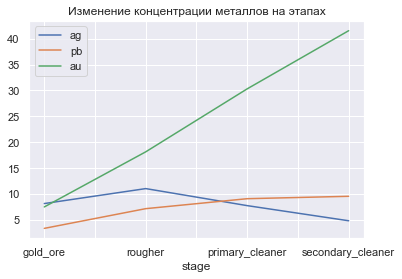

In [32]:
metals.plot(x="stage", title = 'Изменение концентрации металлов на этапах')

## Вывод 
Концентрация золота увеличивается практически линейно от этапа к этапу. На этапе флотации вымывается пустая порода, поэтому концентрации всех металлов увеличиваются. На первичной очистке уменьшается доля серебра, вторичная влияет на концентрацию свинца.

## 2.2 сравнение распределений гранул сырья в выборках<a id="2.2"></a>

сравниваются `df_for_analysis['rougher.input.feed_size']` и `gold_recovery_test['rougher.input.feed_size']`

### Вариант 1. Т-Критерий Стьюдента

Сравним выборки статистическим тестом Т-Критерий Стьюдента.
* формируем нулевую гипотезу H₀: выборки равны
* гипотеза H₁ : выборки различны

In [33]:
# Т-Критерий Стьюдента
def t_criteria_student(frame1, frame2, alpha = .05):
    results = st.ttest_ind(frame1, frame2)
    print('p-значение:', results.pvalue)
# если p-value окажется меньше критический уровеня статистической значимости - отвергнем гипотезу
    if (results.pvalue < alpha):    
        print("Отвергаем нулевую гипотезу. Выборки не равны.")
    else:
        print("Нет оснований для отвержения нулевой гипотезы. Выборки одинаковы")

In [34]:
t_criteria_student(df_for_analysis['rougher.input.feed_size'], gold_recovery_test['rougher.input.feed_size'], alpha = .05)

p-значение: 5.455290325053927e-22
Отвергаем нулевую гипотезу. Выборки не равны.


### Вариант 2. Доверительный интервал для среднего

Смотрим на скольно выборки не равны, используя доверительный интервал среднего.

In [35]:
# доверительный интервал среднего
sample = gold_recovery_train['rougher.input.feed_size']
confidence_interval = st.t.interval( 0.95, len(sample)-1, sample.mean(),sample.sem())
print("95%-ый доверительный интервал среднего обучающей выборки:", confidence_interval)

95%-ый доверительный интервал среднего обучающей выборки: (59.04535086133818, 59.782167621469455)


In [36]:
gold_recovery_test['rougher.input.feed_size'].mean()

56.013034312494

Среднее тестовой выборки не попадает в 95% доверительный интервал обучающей выборки, но недобор составляет всего 0,1. Для обучения модели проблем возникнуть не должно, но посмотрим на распределения на графике. 

### График распределений

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


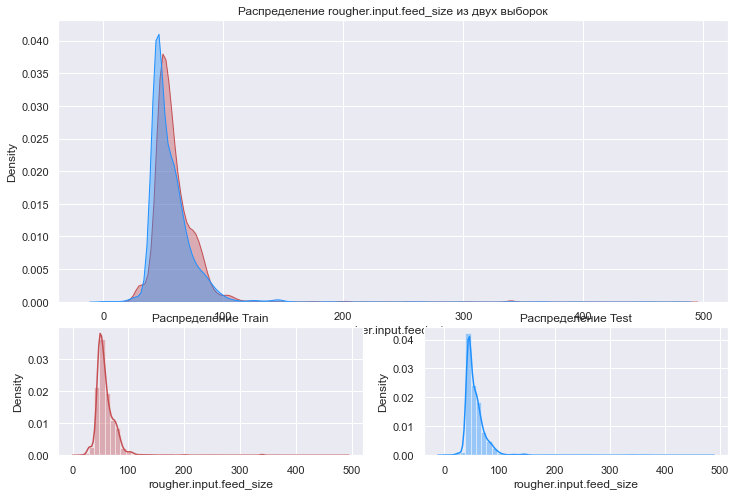

In [37]:
# распределения rougher.input.feed_size
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
sns.kdeplot(df_for_analysis['rougher.input.feed_size'], shade=True, color="r", label="Train", alpha=.4, ax = ax1)
sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], shade=True, color="dodgerblue", label="Test", alpha=.4, ax = ax1)
sns.distplot(df_for_analysis['rougher.input.feed_size'], color="r", ax = ax2)
sns.distplot(gold_recovery_test['rougher.input.feed_size'],color="dodgerblue", ax = ax3)
ax1.set_title('Распределение rougher.input.feed_size из двух выборок')
ax2.set_title('Распределение Train')
ax3.set_title('Распределение Test')
plt.show()

## Вывод 
Распределения гранул сырья в обучающей и тестовой выборках статистически оличаются друг от друга, но похожи. В данных присутствуют выбросы значений.

## 2.3 Исследование концентраций металлов на всех стадиях<a id="2.3"></a>

Для исследования суммарнуй концентрации всех веществ на разных стадиях создадим графики изображающие одномерное распределение вероятностей (box-plot) и двумерные распределения с использованием оценки плотности ядра (KDE). Графики стадий обогащения расположены в порядке технологического процесса. Вначале концентраты, позже "отвальные хвосты".

In [38]:
# Рисует один боксплот
def print_box(dataset, column_name, axn):
    data_select = dataset.loc[:,[column_name]]
    #data_select.hist(bins=50, ax=axn)
    data_select.boxplot(widths = 0.7 , ax=axn)

# Рисует  боксплоты по всем столбцам
def box_plot(dataset, columns, title):
    fig, axis = plt.subplots(1, len(columns), figsize=(12, 5))
    ax = axis.ravel()
    for i in range(len(columns)):
        print_box(dataset, columns[i], ax[i])
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()

# Рисует Графики распределеня
def plot_kde(dataset, columns, title):
    fig, ax1 = plt.subplots(1,1,figsize=(12,5))
    color = ['#ad09a3', 'black', 'y', 'g']
    for i in range(len(columns)):
        sns.kdeplot(dataset[columns[i]], shade=True, color=color[i], alpha=.6)
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()

# Рисует  два графика    
def plot_join (df, column_list, title):
    box_plot(df, column_list, title)
    plot_kde(df, column_list, 'Общее распределение веществ')

Назначаем переменные параметров обогащения по этапам процесса обогащения золотосодержащей руды.

In [39]:
# gold_ore
ore_feed = (['rougher.input.feed_ag', 'rougher.input.feed_pb','rougher.input.feed_au', 'rougher.input.feed_sol'])

# rougher
rougher_output_concentrate = (
    ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol'])
rougher_output_tail = (
    ['rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_au', 'rougher.output.tail_sol'])

# primary_cleaner
primary_cleaner_output_concentrate = (
    ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_sol'])
primary_cleaner_output_tail = (
    ['primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_sol'])

# secondary_cleaner
secondary_cleaner_output_tail = (
    ['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_sol'])

# final
final_concentrate = (['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_sol'])
final_tail = (['final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_au', 'final.output.tail_sol'])


### Распределения обогащения концентратов

### Концентраты

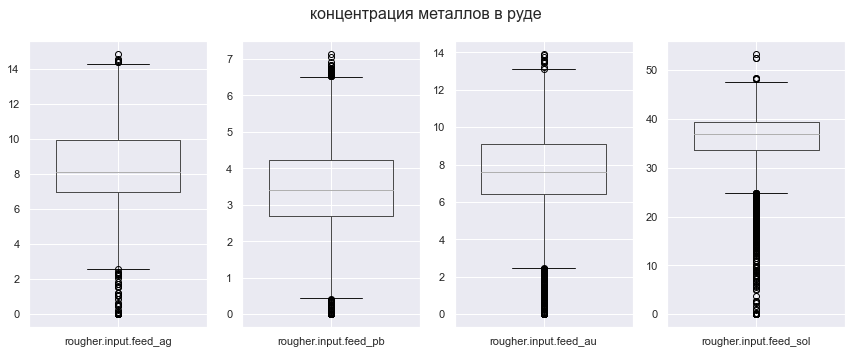

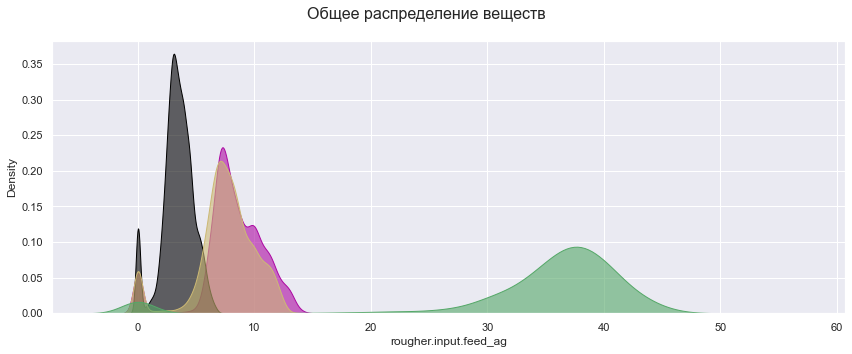

In [40]:
plot_join(df_for_analysis, ore_feed, 'концентрация металлов в руде')

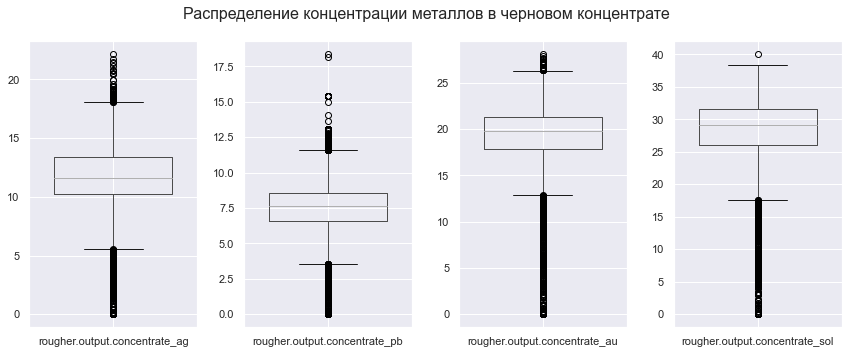

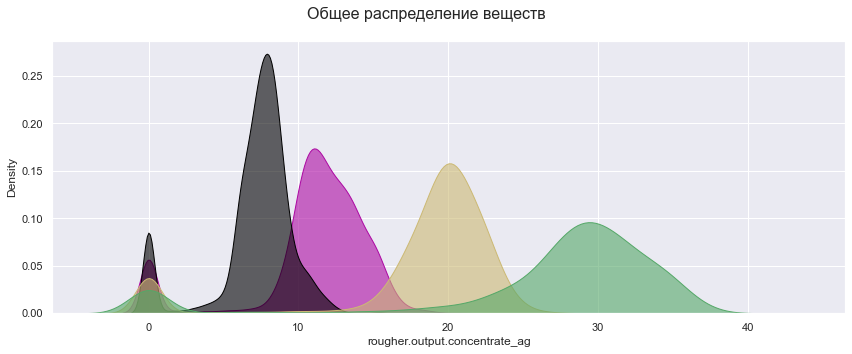

In [41]:
plot_join(df_for_analysis, rougher_output_concentrate, 'Распределение концентрации металлов в черновом концентрате')

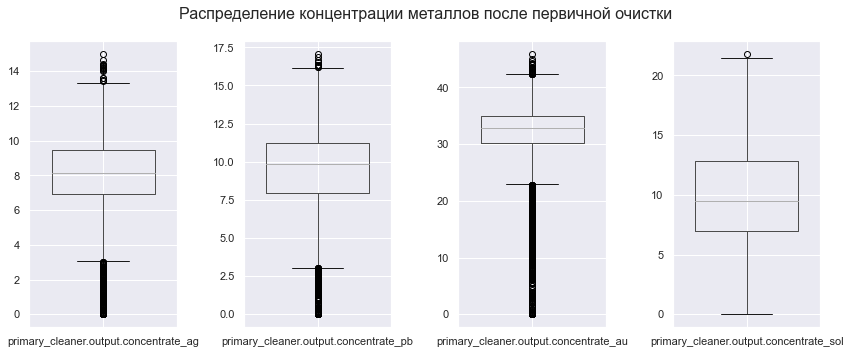

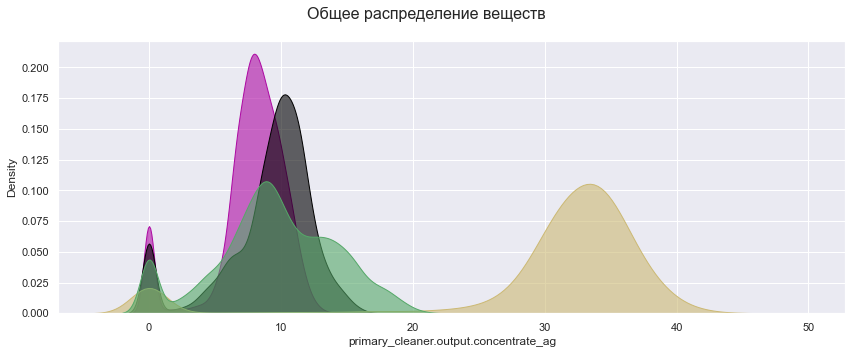

In [42]:
plot_join(df_for_analysis, primary_cleaner_output_concentrate, 'Распределение концентрации металлов после первичной очистки')

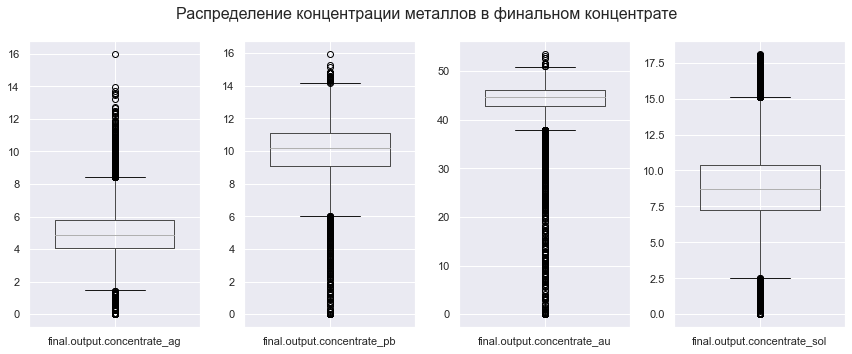

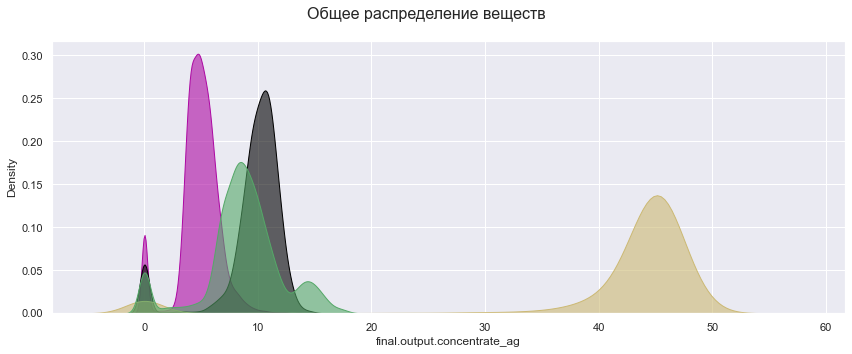

In [43]:
plot_join(df_for_analysis, final_concentrate, 'Распределение концентрации металлов в финальном концентрате')

### Хвосты 

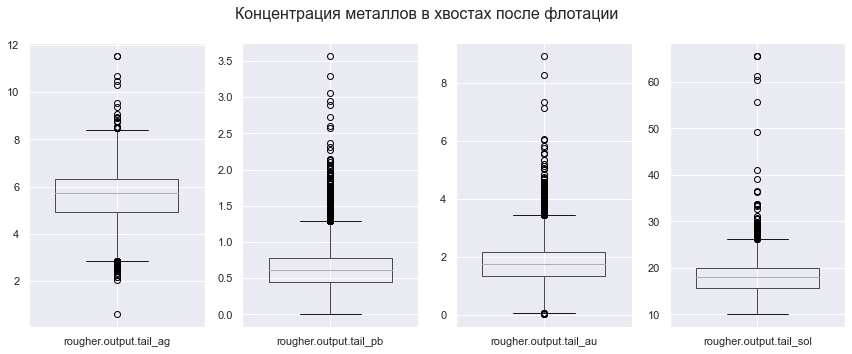

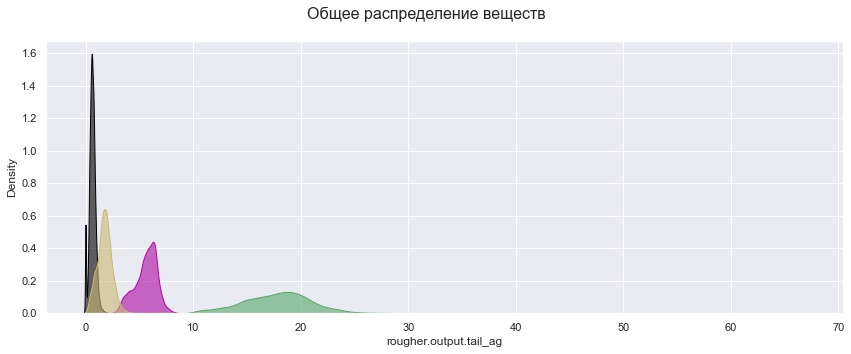

In [44]:
plot_join(df_for_analysis, rougher_output_tail, 'Концентрация металлов в хвостах после флотации')

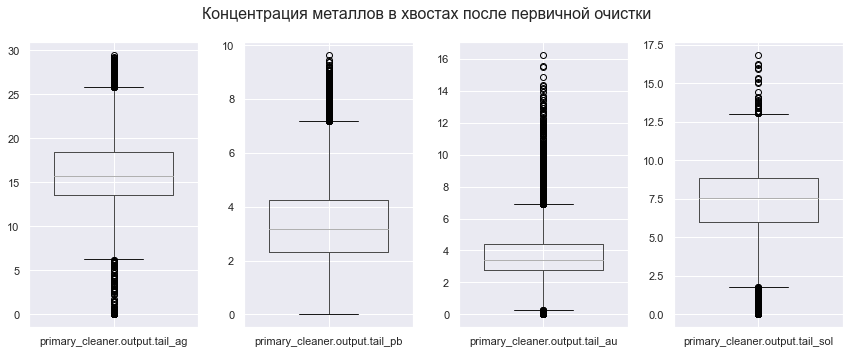

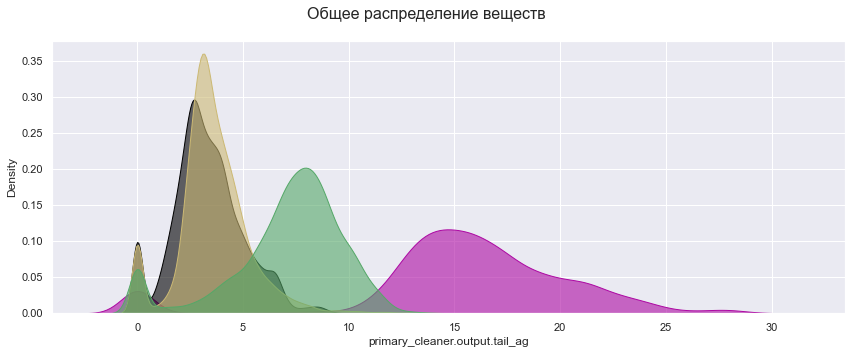

In [45]:
plot_join(df_for_analysis, primary_cleaner_output_tail, 'Концентрация металлов в хвостах после первичной очистки')

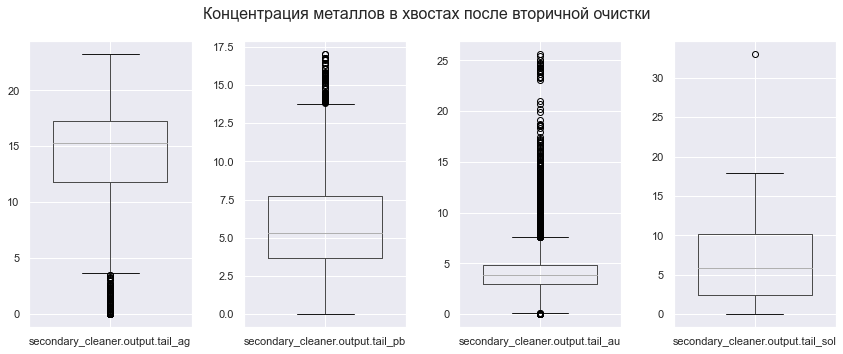

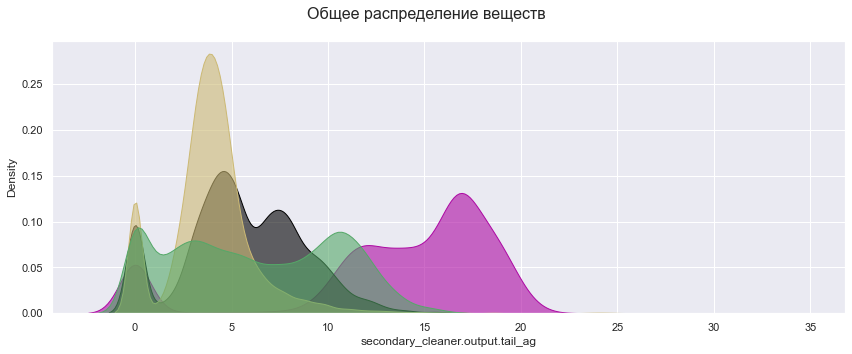

In [46]:
plot_join(df_for_analysis, secondary_cleaner_output_tail, 'Концентрация металлов в хвостах после вторичной очистки')

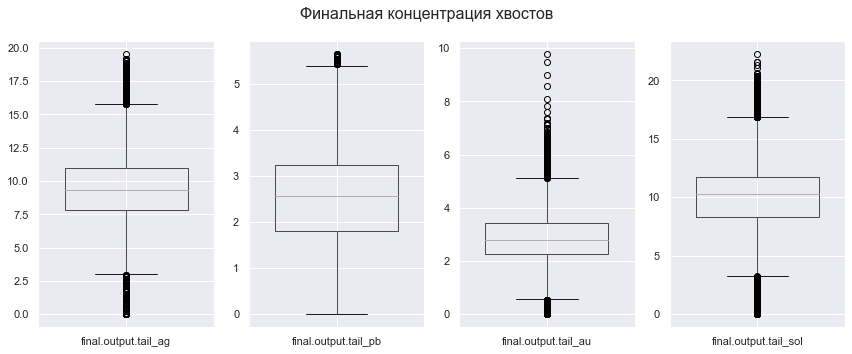

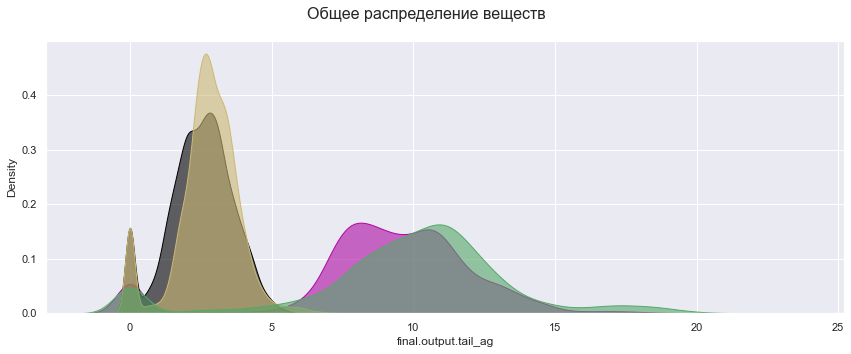

In [47]:
plot_join(df_for_analysis, final_tail, 'Финальная концентрация хвостов')

## Вывод 
В данных имеются выбросы. Наиболее, для нас, значимые - это выбосы в нижней зоне, около нуля на этапе руды. Верхние выбросы вполне себе могут существовасть в природе. Обработаем на датасетах `gold_recovery_train` и `gold_recovery_test` от выбросов `3%` каждого элемента.

In [48]:
# column_list_drop_ejection = ore_feed
# column_list_drop_ejection = ore_feed + ['rougher.input.feed_size']
column_list_drop_ejection = (['rougher.input.feed_au'])
#    + rougher_output_concentrate
#    + rougher_output_tail
#    + primary_cleaner_output_concentrate
#    + primary_cleaner_output_tail
#    + secondary_cleaner_output_tail
#    + final_concentrate
#    + final_tail



In [49]:
gold_recovery_train = drop_ejection(gold_recovery_train, column_list_drop_ejection, .01)

*** режим отладки. см. def drop_ejection ***
(15134, 54) rougher.input.feed_au lower: 0.000, upper: 11.857


In [50]:
# Остаток от данных
print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

(14755, 54)
(5742, 54)


## Вывод 
Выборки проанализированы подготовлены для обучения моделей. Избавились от выбросов в информации, поступающей на вход этапа флотации.

# 3. Модель<a id="3"></a>

Нам предстоит обучить две модели для различных этапов обогащения. 
1. Первая модель - для прогноза полного цикла обогощения от золотосодержащей руды до финального концентрата. 
    
    Этапы обучения:
    - Разбиение выборки
    - Отбор лучших моделей для обучения
    - Отбор признаков по важности случайного леса и линейные наименьшие квадраты с регуляризацией l2 
    - Улучшение модели методом стандартизации данных StandardScaler()
    - Улучшение модели путем подбора гиперпараметров RandomForestRegressor 
    - Оценка качества работы модели на проверочных данных
    
    
2. Вторая модель - прогнозирует производство чернового концентрата на этапе флотации
   
    Этапы обучения:
    - Разбиение выборки
    - Стандартизация данных
    - Обучение базовой модели (RF) 
    - Анализ показателей важности признаков RandomForestRegressor
    - Отбор признаков. Метод главных компонент (PCA) 
    - Обучение базовой модели после применения к данным метода главных компонент ( RF + PCA)
    - Обширный поиск гиперпараметров с RandomizedSearchCV 
    - Оптимизация гиперпараметров с GridSearchCV Hyperparameter Tuning для модели (RF + PCA + HT)
    - Оценка качества работы модели на проверочных данных 
    
    
3. расчет метрики "Итоговый sMAPE"

4. Проверка моделей на адекватность

## Метрика качества<a id="3.2_1"></a>

В проекте используется метрика `sMAPE` (Symmetric mean absolute percentage error) - симметричная средняя абсолютная процентная ошибка. Это мера точности, основанная на процентных (или относительных) ошибках. Модуль разницы между предсказанием
модели и истинным значением мы делим на их среднее (или истинное значение). Метрика объясняется процентом ошибок в прогнозе, относительно фактических данных.

Итоговый `sMAPE` это `25% sMAPE флотации + 75% sMAPE финального`.

Для обучения моделей создана метрика `scor_MAPE`.

In [51]:
def sMAPE(target, predict):
    sMAPE = ((abs(target - predict) / ((abs(target) + abs(predict)) / 2)).sum() / len(target)) * 100
    return sMAPE

def result_sMAPE(sMAPE_rougher, sMAPE_final):
    return sMAPE_rougher * 0.25 + sMAPE_final * 0.75

scor_MAPE = make_scorer(sMAPE, greater_is_better = False)

## Разбиение выборки<a id="3.11"></a>

Отделяем в обучающей и тестовой выборке целевые признаки для финальной модели, убираем целевой признак модели флотации.  Сохраняем в отдельных выборках.

In [52]:
def x_y_split(df, target):
    x = df.drop(target, axis=1)
    y = df[target]
    return x, y

In [53]:
# full разбиение на  features target
features_train, target_train = x_y_split(gold_recovery_train, 'final.output.recovery')
features_test, target_test = x_y_split(gold_recovery_test, 'final.output.recovery')

#  удаление лишних целевых признаков
features_train = features_train.drop(['rougher.output.recovery'], axis=1)
features_test = features_test.drop(['rougher.output.recovery'], axis=1)

Для того, чтобы модель флотации, как первый этап обогащения руды, не обучалась от признаков последующего производства, выделим данные отдельную выборку, содержащую первичные данные для производства чернового концентрата. `rougher_recovery_train`, `rougher_recovery_test`. Далее аналогично отделим в выборках целевой признак.

In [54]:
#rougher Данные для прогноза флотации
features_rougher_recovery = [
        'rougher.calculation.sulfate_to_au_concentrate',
        'rougher.calculation.floatbank10_sulfate_to_au_feed',
        'rougher.calculation.floatbank11_sulfate_to_au_feed',
        'rougher.calculation.au_pb_ratio', 
        'rougher.input.feed_ag',
        'rougher.input.feed_pb', 
        'rougher.input.feed_rate',
        'rougher.input.feed_size', 
        'rougher.input.feed_sol',
        'rougher.input.feed_au', 
        'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.output.recovery',
        'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
        'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']

In [55]:
rougher_recovery_train = gold_recovery_train.loc[:,gold_recovery_train.columns.isin(features_rougher_recovery)]
rougher_recovery_test = gold_recovery_test.loc[:,gold_recovery_test.columns.isin(features_rougher_recovery)]

In [56]:
f_train, t_train = x_y_split(rougher_recovery_train, 'rougher.output.recovery')
f_test, t_test = x_y_split(rougher_recovery_test, 'rougher.output.recovery')

In [57]:
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)
print(f_train.shape, t_train.shape)
print(f_test.shape, t_test.shape)

(14755, 52) (14755,)
(5742, 52) (5742,)
(14755, 22) (14755,)
(5742, 22) (5742,)


In [58]:
print(f_train.shape, t_train.shape)
print(f_test.shape, t_test.shape)

(14755, 22) (14755,)
(5742, 22) (5742,)


##  Расчет для финального концентрата<a id="3.1"></a>

Финальный концентрат это результат полного цикла обогащения золотоносной руды. Состоит из этапов флотации, первичной и вторичной очистки. 

## Отбор лучших моделей для обучения<a id="3.12"></a>

Произведем первичный анализ работы различных базовых моделей кроссвалидацией с метрикой scor_MAPE и выбор перспективной модели.

In [59]:
kfold = 5 #количество подвыборок для валидации
itog_val = {} #список для записи результатов кросс валидации разных алгоритмов
def scores_models (features, target):
    # print('*** режим отладки. см. def scores_models ***') # отладка
    model_forest = RandomForestRegressor(random_state=12345, n_estimators = 30)
    model_tree = DecisionTreeRegressor(random_state=12345)
    model_lr = LinearRegression() 

    scores = cross_val_score(model_forest, features, target, scoring = scor_MAPE, cv = kfold) 
    itog_val['RandomForestRegressor'] = scores.mean()
    scores = cross_val_score(model_tree, features, target, scoring = scor_MAPE, cv = kfold)
    itog_val['DecisionTreeRegressor'] = scores.mean()
    scores = cross_val_score(model_lr, features, target, scoring = scor_MAPE, cv = kfold)
    itog_val['LinearRegression'] = scores.mean()


    # средний показатель тестов перекрестной проверки каждой модели:
    (pd.DataFrame.from_dict(data = itog_val, orient='index')
                 .plot(grid = True, 
                       kind='bar', 
                       legend=False, 
                       title = 'средний показатель перекрестной проверки каждой модели'))

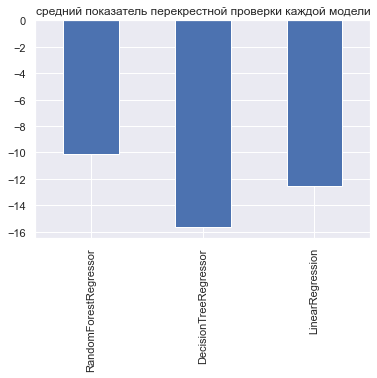

In [60]:
scores_models (features_train, target_train)

## Отбор признаков по важности случайного леса и линейные наименьшие квадраты с регуляризацией l2<a id="3.13"></a>

Отбор лучших признаков производим двумя методами конкурентно: На основе важности обученного RandomForestRegressor и линейного метода `ridge` из пакета `sklearn.linear_model`. Метрикой будет `cross_val_score` на основе модели `LinearRegression()` и `scoring = scor_MAPE`. Алгоритм перебират в цикле количество признаков, указанное в переменных вызывает оценочные методы, лучший по оценке `cross_val_test` результат возвращаетв виде датафреймов `train`, `test`. Рисует статистику

In [61]:
# тест кросс валидационный
kfold = 5 #количество подвыборок для валидации
def cross_val_test(features, target, model = (RandomForestRegressor(random_state=12345, n_estimators = 30))):
    scores = cross_val_score(model, features, target, cv = kfold, scoring = scor_MAPE) 
    return scores.mean()

In [62]:
# вариант 1 RandomForestRegressor.feature_importances_
def Forest_feature_importances(features_train, target_train, features_test, n_features = 30):
    '''обучается лес, выводит n_features лучшие признаки'''
    # print('*** режим отладки. см. def Forest_feature_importances ***') # отладка
    model = RandomForestRegressor(random_state=12345, n_estimators = 30)
    model = model.fit(features_train, target_train)
    model.feature_importances_

    top_feature = pd.DataFrame(
        np.column_stack((model.feature_importances_, features_train.columns))).sort_values(by = 0, ascending=False)

    # отберем n_features значащих признака
    out_features_train = features_train.loc[:,features_train.columns.isin(top_feature.head(n_features)[1])]

    # уравниваем  признаки для test
    out_features_test = features_test.loc[:, features_test.columns.isin(out_features_train.columns)]   
    
    return out_features_train, out_features_test

# вариант 2 Ridge 
# from sklearn.linear_model import Ridge
                                 
def linear_ridge(features_train, target_train, features_test, n_features = 30):
    # print('*** режим отладки. см. def linear_ridge ***') # отладка
    '''обучается ridge, выводит n_features лучшие признаки'''
    clf = Ridge(alpha=1.0, random_state=12345)
    clf.fit(features_train, target_train)

    top_feature = pd.DataFrame(
        np.column_stack(((abs(clf.coef_)), features_train.columns))).sort_values(by = 0, ascending=False)
    #top_feature.head(3) # отладка
    # отберем n_features значащих признака
    out_features_train = features_train.loc[:,features_train.columns.isin(top_feature.head(n_features)[1])]
    # уравниваем  признаки для test 
    out_features_test = features_test.loc[:, features_test.columns.isin(out_features_train.columns)]

    return out_features_train, out_features_test

# Строит графики с результатами обучения при различных гиперпараметрах

def plot_fselection_features(data):
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot('n_features', 'cross_score', 
                 hue='method', data=data, palette="muted", linewidth=4)
    ax.set(xlabel = "Количество признаков", ylabel ='Качество')
    ax.set_title('Качество отбора признаков',fontsize=20)
    f.tight_layout()

In [63]:
# Перебират в цикле количество признаков, вызывает оценочные методы, лучший по оценке cross_score результат возвращает
# в виде dataset train, test. Рисует статистику.
def selection_features(features_train, target_train, features_test):
    print('*** режим отладки. см. def selection_features ***') # отладка
    max_n_features = 18
    step_n_features = 2
    best_selection_features = {
        'cross_val_scores':101.0,
        'features_train':'',
        'features_test':''
    }
    for_plot = []
    for n in range(3, max_n_features, step_n_features):
        print('n_features: ', n)
        features_train_out, features_test_out = linear_ridge(features_train, target_train, features_test, n)
        cross_score = cross_val_test(features_train_out, target_train)
        for_plot.append([n, cross_score, 'Linear least squares'])
        print('Ridge', abs(cross_score), 'vs', abs(best_selection_features.get('cross_val_scores'))) # отладка
        if abs(cross_score) < abs(best_selection_features.get('cross_val_scores')):
            print('Win. Ridge:', features_train_out.shape )    # отладка
            best_selection_features['cross_val_scores'] = cross_score
            best_selection_features['features_train'] = features_train_out
            best_selection_features['features_test'] = features_test_out
    

        features_train_out, features_test_out = Forest_feature_importances(features_train, target_train, features_test, n)
        cross_score = cross_val_test(features_train_out, target_train)
        for_plot.append([n, cross_score, 'importances with forests'])
        
        print('Forest', abs(cross_score), 'vs',  abs(best_selection_features.get('cross_val_scores'))) # отладка
              
        if abs(cross_score) < abs(best_selection_features.get('cross_val_scores')):
            print('Win. Forest:', features_train_out.shape )      # отладка
            best_selection_features['cross_val_scores'] = cross_score
            best_selection_features['features_train'] = features_train_out
            best_selection_features['features_test'] = features_test_out

    # print(best_selection_features)      # отладка
    df = pd.DataFrame(for_plot, columns = ['n_features', 'cross_score', 'method'])
    plot_fselection_features(df)

    return best_selection_features.get('features_train'), best_selection_features.get('features_test')#, df   # отладка

*** режим отладки. см. def selection_features ***
n_features:  3
Ridge 10.713383715514272 vs 101.0
Win. Ridge: (14755, 3)
Forest 9.704997907822577 vs 10.713383715514272
Win. Forest: (14755, 3)
n_features:  5
Ridge 10.619374314366105 vs 9.704997907822577
Forest 10.0943578197672 vs 9.704997907822577
n_features:  7
Ridge 10.117210762594054 vs 9.704997907822577
Forest 10.085606987321807 vs 9.704997907822577
n_features:  9
Ridge 9.943121391507326 vs 9.704997907822577
Forest 9.795683364117533 vs 9.704997907822577
n_features:  11
Ridge 9.622040358314154 vs 9.704997907822577
Win. Ridge: (14755, 11)
Forest 9.507142417552238 vs 9.622040358314154
Win. Forest: (14755, 11)
n_features:  13
Ridge 9.841856458231337 vs 9.507142417552238
Forest 9.421153536431147 vs 9.507142417552238
Win. Forest: (14755, 13)
n_features:  15
Ridge 9.744998452324584 vs 9.421153536431147
Forest 9.906080798536228 vs 9.421153536431147
n_features:  17
Ridge 9.778383553981502 vs 9.421153536431147
Forest 9.997353987165495 vs 9.4

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


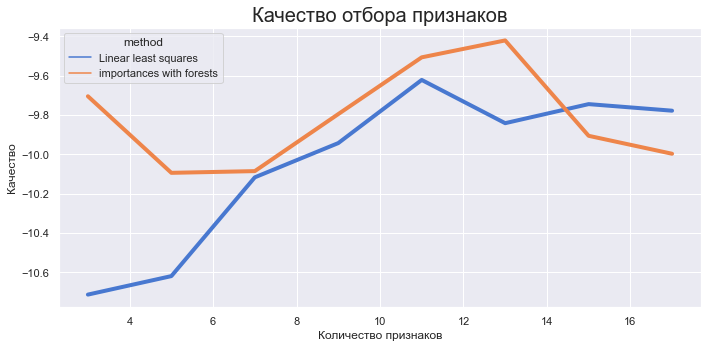

In [64]:
# займет времени. 
features_train, features_test = selection_features(features_train, target_train, features_test)

In [65]:
print('выборки с признаками после отбора')
print('features_train:', features_train.shape)
print('features_test:', features_test.shape)

выборки с признаками после отбора
features_train: (14755, 13)
features_test: (5742, 13)


Признаки отобраны конкурентно.

## Улучшение модели

Улучшать модель будем подбором гиперпараметров RandomForestRegressor `greater_depth` `step_depth` `n_estimator` `step_estimators`

In [66]:
def scaler_features(features_train, features_test):
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)
    return features_train_scaled, features_test_scaled

# Глобальные переменные
best_model_score = 101.0 # это меньший параметр
best_train_model: object()


# возвращает обученную модель и время обучения. Лучшую модель и метрику записывает в переменные best_train_model, sMAPE
def get_model_score(features, target, model):
    # print('*** режим отладки. см. def get_model_score ***') # отладка
    global best_train_model
    global best_model_score
    model_score = cross_val_test(features, target, model)
    # model_score = sMAPE(target, model.predict(features))   # отладка
    if abs(model_score) < abs(best_model_score):  # Знак зависит от метрики. сейчас меньше - лучше
        # print(model_score, 'vs', best_model_score)  # отладка
        #print('win', model_score)   # отладка
        #print('записан', model_score) # отладка
        best_model_score = model_score
        best_train_model = model
        #print('прочитан', best_model_score) # отладка
    return model_score.mean()

# Гиперпараметры
small_depth = 2 # min_depth
greater_depth = 17  #  max_depth
step_depth = 4 # шаг depth
start_n_estimator = 30 # min n_estimators
n_estimator = 200  # n_estimators
step_estimators = 20 # шаг n_estimators
# подбирает гиперпараметры. выводит информацию о лучшей модели.
def search_hyperparameters(features, target):
    # print('*** режим отладки. см. def search_hyperparameters ***') # отладка
    global best_model_score
    global best_train_model
    best_model_score = 101.0 # это меньший параметр
    best_train_model = RandomForestRegressor()
    compare_score = best_model_score
    for depth, estimator in itertools.product(range(small_depth,greater_depth,step_depth), range(start_n_estimator,n_estimator,step_estimators)):
        model = RandomForestRegressor(
            random_state=12345, 
            max_depth=depth, 
            n_estimators=estimator,
            max_features = 'sqrt',
            min_samples_leaf = 50,
            min_samples_split = 40,
            bootstrap = True
        )
        model_score = get_model_score(features, target, model)
        print('model_score: {:.3f}, depth: {}, n_estimators: {}'.format(model_score, depth, estimator))
    if abs(best_model_score) < abs(compare_score):
        print('==='*20)
        print('найдена лучшая модель: model_score: {:.3f}\n'.format(best_model_score))
    else:
        print('==='*20)
        print('Лучшего результата нет')        

### Стандартизация данных<a id="3.14"></a>

Предварительно выполним «центровку» и «стандартизацию» данных путём их масштабирования. Масштабирование выполняется из-за того, что разные величины выражены в разных единицах измерения. 

In [67]:
# стандартизируем наши обучающие данные
f_train_scaler, f_test_scaler = scaler_features(features_train, features_test)

### Подбор гиперпараметров<a id="3.15"></a>

In [68]:
# занимает много времени. можно параметры поменьше сделать
search_hyperparameters(f_train_scaler, target_train)

model_score: -9.487, depth: 2, n_estimators: 30
model_score: -9.536, depth: 2, n_estimators: 50
model_score: -9.590, depth: 2, n_estimators: 70
model_score: -9.600, depth: 2, n_estimators: 90
model_score: -9.611, depth: 2, n_estimators: 110
model_score: -9.588, depth: 2, n_estimators: 130
model_score: -9.596, depth: 2, n_estimators: 150
model_score: -9.588, depth: 2, n_estimators: 170
model_score: -9.587, depth: 2, n_estimators: 190
model_score: -8.651, depth: 6, n_estimators: 30
model_score: -8.668, depth: 6, n_estimators: 50
model_score: -8.685, depth: 6, n_estimators: 70
model_score: -8.690, depth: 6, n_estimators: 90
model_score: -8.694, depth: 6, n_estimators: 110
model_score: -8.685, depth: 6, n_estimators: 130
model_score: -8.685, depth: 6, n_estimators: 150
model_score: -8.687, depth: 6, n_estimators: 170
model_score: -8.686, depth: 6, n_estimators: 190
model_score: -8.556, depth: 10, n_estimators: 30
model_score: -8.564, depth: 10, n_estimators: 50
model_score: -8.606, depth: 

In [69]:
print('лучшая модель', best_train_model)

лучшая модель RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=50,
                      min_samples_split=40, n_estimators=30,
                      random_state=12345)


### Оценка качества работы моделеи на проверочных данных<a id="3.16"></a>

Оценим результат обучения модели на тестовых данных финального концентрата метрикой MAPE

In [70]:
model_final = best_train_model
model_final = model_final.fit(f_train_scaler, target_train)

predict = model_final.predict(f_test_scaler)
sMAPE_final = sMAPE(target_test, predict)
                   
print('Ошибка прогноза финального концентрата составляет {:.1f} % от фактических значений'.format(sMAPE_final))

Ошибка прогноза финального концентрата составляет 9.3 % от фактических значений


## Расчет для чернового концентрата <a id="3.2"></a>

Черновой концентрат это результат обогащения золотосодержащей руды этапа флотации. Зависит от физико-химического состояния флотационной пульпы - смеси твердых частиц и жидкости.

In [71]:
# датасет для rougher
print(f_train.shape, t_train.shape)
print(f_test.shape, t_test.shape)

(14755, 22) (14755,)
(5742, 22) (5742,)


### Стандартизация данных<a id="3.22"></a>

Масштабируем признаки, конвертируем `y_train` из типа данных `Pandas Series` в массив `NumPy`, для того чтобы позже модель смогла бы работать с соответствующими целевыми показателями. 

In [72]:
f_train_scaled, f_test_scaled = scaler_features(f_train, f_test)
t_train = np.array(t_train)

### Обучение базовой модели  (RF)<a id="3.23"></a>

Инициализируем модель.

In [73]:
base_model = RandomForestRegressor(random_state=12345, n_estimators = 30)
base_model.fit(f_train_scaled, t_train)
predict = base_model.predict(f_test_scaled)
sMAPE_rougher = sMAPE(t_test, predict)
print('sMAPE', sMAPE_rougher)

sMAPE 14.511402416872762


### Показатели важности признаков<a id="3.24"></a>
Выделим показатели важности признаков модели `RandomForestRegressor` с помощью атрибута `feature_importances_`.

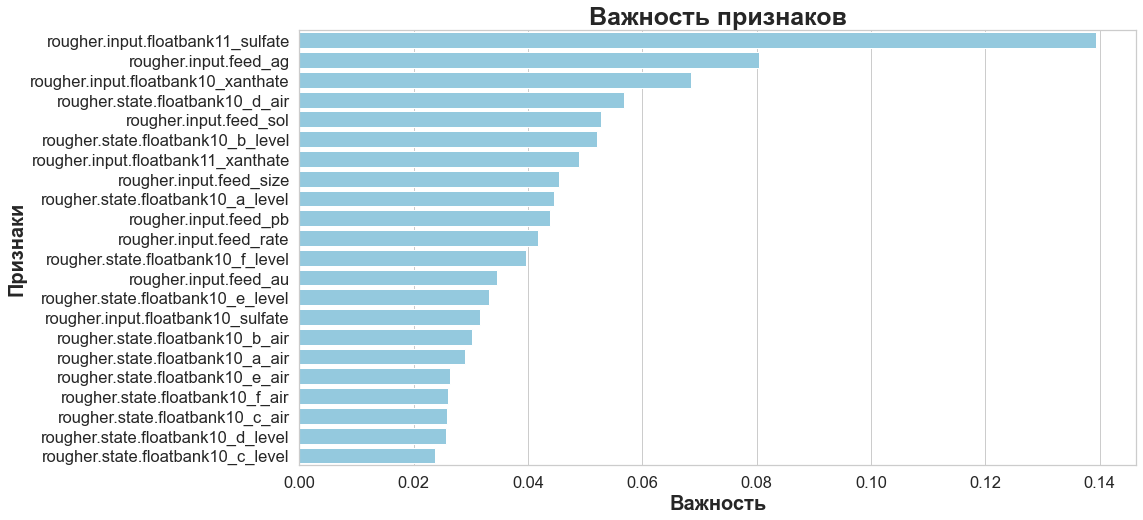

None

In [74]:
feats = {}
for feature, importanc in zip(f_train, base_model.feature_importances_): # f_train не масштабированные данные
    feats[feature] = importanc
    
importanc = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importanc'})
importanc = importanc.sort_values(by='Importanc', ascending=False)
importanc = importanc.reset_index()
importanc = importanc.rename(columns={'index': 'Features'})
# display(importanc)
sns.set(font_scale = 4)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.5)
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.barplot(x = importanc['Importanc'], y = importanc['Features'], data=importanc, color='skyblue')
plt.xlabel('Важность', fontsize=20, weight = 'bold')
plt.ylabel('Признаки', fontsize=20, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())


### Отбор признаков. Метод главных компонент (PCA)<a id="3.25"></a>
Используя PCA, можно изучить кумулятивную выборочную дисперсию этих признаков для того чтобы понять то, какие признаки объясняют большую часть дисперсии в данных. Инициализируем объект `PCA (pca_test)`, указывая количество признаков, которые нужно рассмотреть. Затем передаём в `pca_test` масштабированные данные `f_train_scaled`, пользуясь методом `pca_test.fit()`. После этого визуализируем данные.

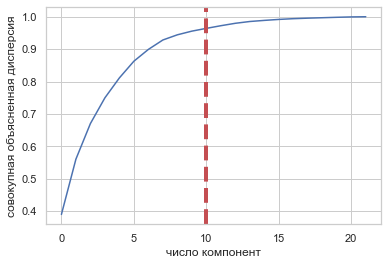

None

In [75]:
pca_test = PCA(n_components = 22) # количество признаков (компонент)
pca_test.fit(f_train_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('число компонент')
plt.ylabel('совокупная объясненная дисперсия')
plt.axvline(linewidth = 4, color = 'r', linestyle = '--', x = 10, ymin = 0, ymax = 1)#  x вертикаль. выбрано компонент.
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative_Variance_Ratio'] = cvr
pca_df['Explained_Variance_Ratio'] = evr


После того, как число используемых компонент превышает 10, рост их количества не очень сильно повышает объяснённую дисперсию

In [76]:
display(pca_df.head(10))

,Cumulative_Variance_Ratio,Explained_Variance_Ratio
0,0.389803,0.389803
1,0.560418,0.170615
2,0.670285,0.109866
3,0.749712,0.079428
4,0.811239,0.061527
5,0.862745,0.051506
6,0.899171,0.036426
7,0.928256,0.029085
8,0.944232,0.015976
9,0.955573,0.011341


Пояснение PCA: 10 главных компонент позволяют объяснить `95%` дисперсии данных. Другие 12 компонент объясняют менее `5%` дисперсии, значит от них можно отказаться. 

Воспользуемся `PCA.fit-transform` для уменьшения числа компонент с 22 до 10 для `f_train_scaled` и `f_test_scaled`. Запишем наборы данных в `f_train_scaled_pca` и в `f_test_scaled_pca`.

In [77]:
pca = PCA(n_components=10)
pca.fit(f_train_scaled)
f_train_scaled_pca = pca.transform(f_train_scaled)
f_test_scaled_pca = pca.transform(f_test_scaled)

### Обучение базовой модели после применения к данным метода главных компонент ( RF + PCA)<a id="3.26"></a>
Чтобы узнать о том, есть ли улучшения в точности предсказаний, выдаваемых моделью обучим базовую модель с выборкой пониженной размерности `f_train_scaled_pca`

In [78]:
model_pca = RandomForestRegressor(random_state=12345, n_estimators = 30)
model_pca = model_pca.fit(f_train_scaled_pca, t_train)
predict = model_pca.predict(f_test_scaled_pca)
sMAPE_rougher = sMAPE(t_test, predict)
print('sMAPE', sMAPE_rougher)

sMAPE 10.986933827431338


### Оптимизация гиперпараметров RandomizedSearchCV<a id="3.27"></a>
`RandomizedSearchCV` позволяет довольно грубо исследовать широкие диапазоны значений за меньшее время. Получив нужные диапазоны, мы можем более точно выбрать гиперпараметры.

In [79]:
# долго
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(model_pca, 
                        param_dist, 
                        n_iter = 50, # количество заходов
                        cv = 3, 
                        verbose = 1,
                        scoring = scor_MAPE,
                        n_jobs=-1, 
                        random_state=12345)
rs.fit(f_train_scaled_pca, t_train)
display(rs.best_params_)
print('sMAPE',rs.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.1s finished


{'n_estimators': 32,
 'min_samples_split': 50,
 'min_samples_leaf': 50,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': False}

sMAPE -11.745545626227228


При значениях параметров `n_iter =`  и `cv =` , мы создем  `(n_iter * cv)` RF-моделей, случайно выбирая комбинации гиперпараметров. лучшие атрибуты можно получть, если обратиться к атрибуту `best_params_`.

Получаем датафрейм от `rs.cv_results_`, для того чтобы визуализировать и выяснить, в каком диапазоне значений стоит продолжать поиск.

In [80]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(5)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,32,50,50,log2,11,False,-11.745546,1
1,55,14,50,sqrt,15,False,-11.773612,2
2,10,2,2,log2,6,True,-11.791547,3
3,10,2,26,log2,6,True,-11.798214,4
4,100,14,38,sqrt,6,True,-11.802016,5


Чтобы понять в какую сторону идти в поисках параметроз, создадим графики.

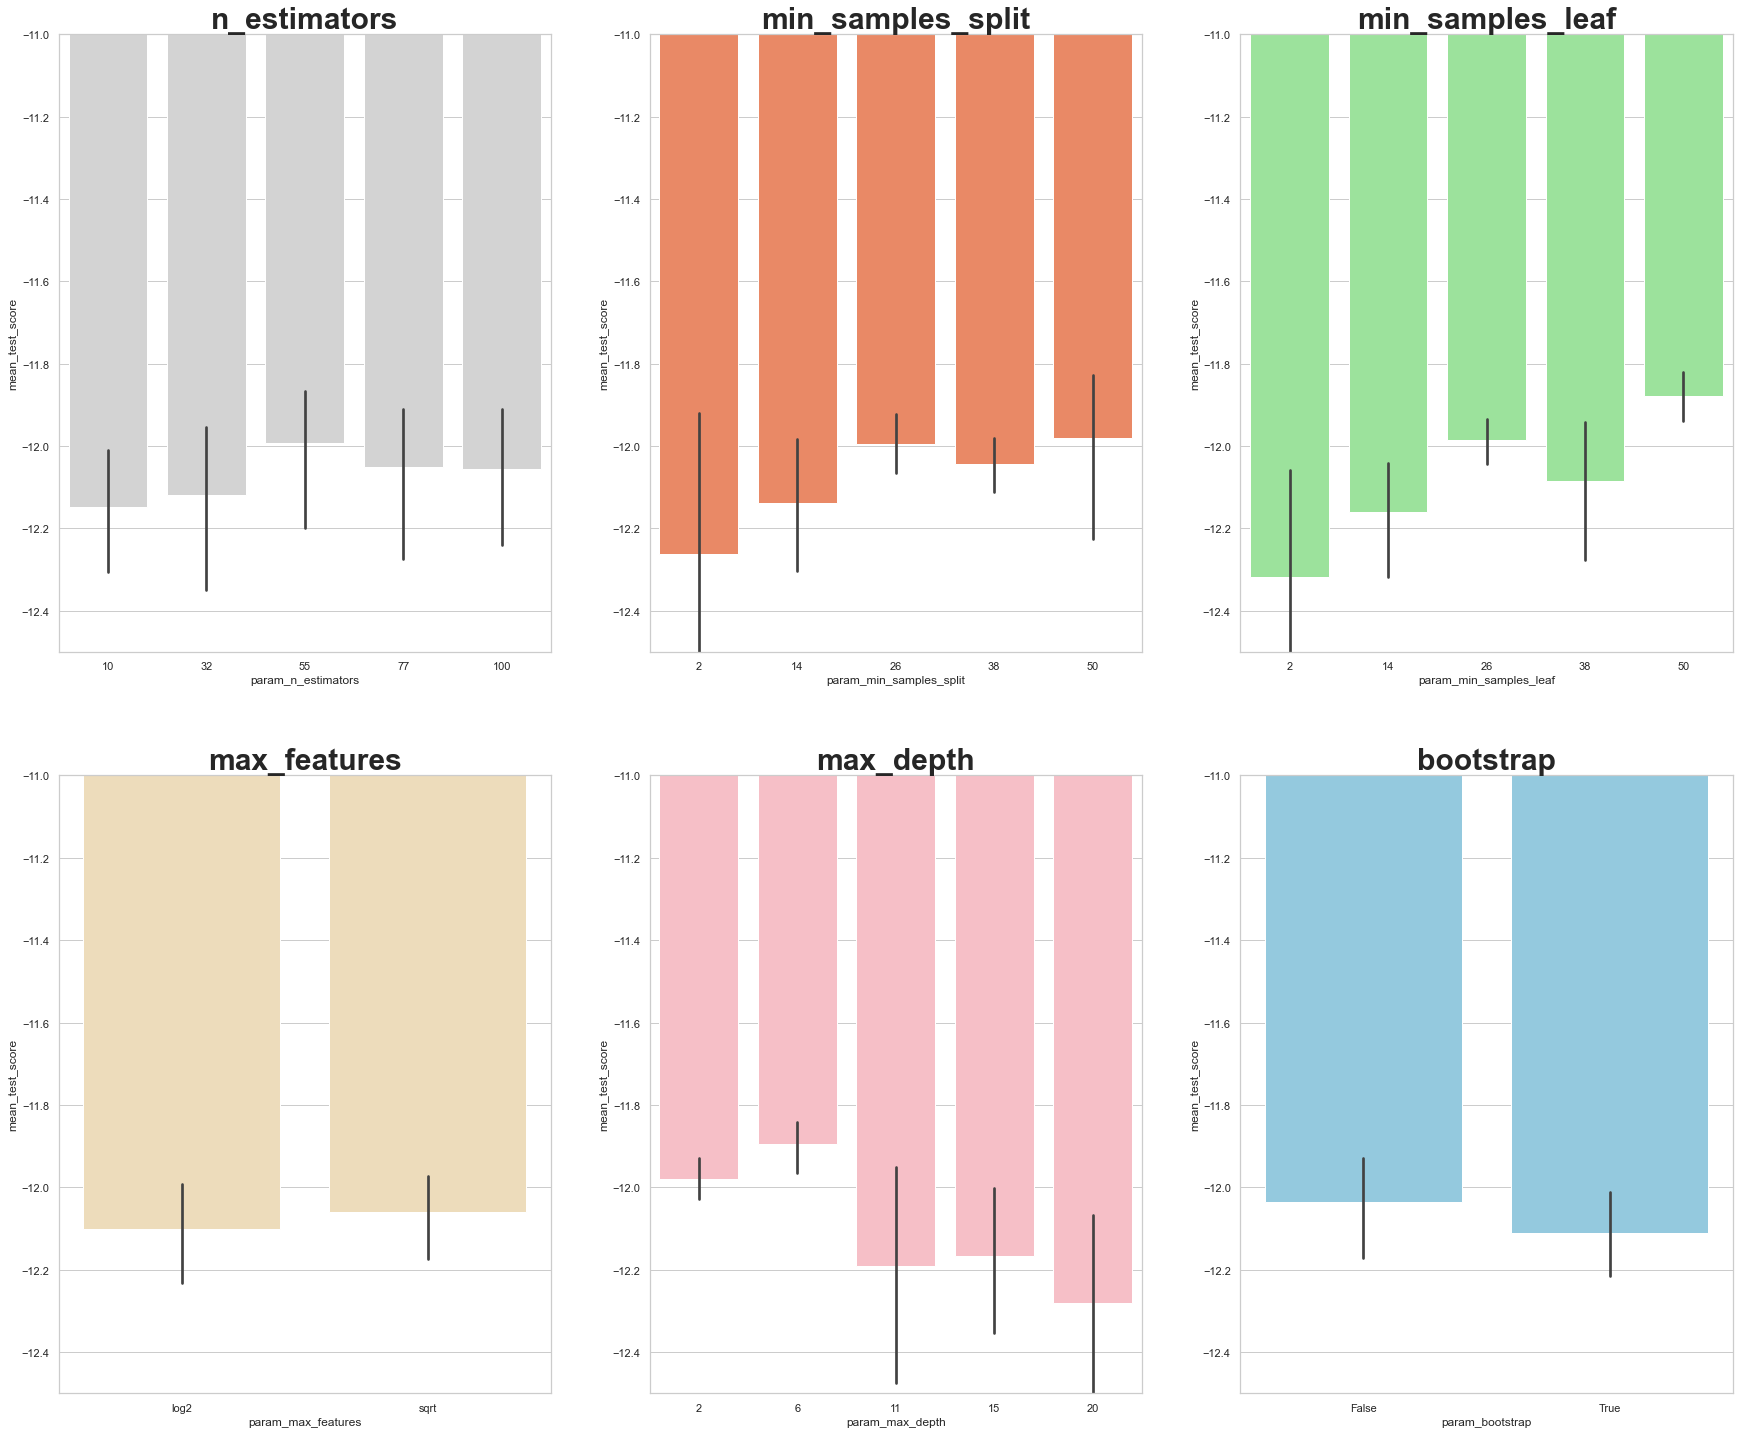

In [81]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([-12.5,-11]), 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([-12.5,-11]), 
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([-12.5,-11]), 
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([-12.5,-11]), 
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([-12.5,-11]), 
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([-12.5,-11])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

**Анализ значений гиперпараметров**

Графики показывают, как, в среднем, каждое значение гиперпараметра влияет на модель.

* **n_estimators:** значения около 55 Можно исследовать несколько значений около этого гиперпараметра.
* **min_samples_split:** Хорошо выглядит и значения 26 и 50 показывают наилучшие средние результаты.
* **min_samples_leaf:** 26 и 50 выглядят перспективно, возможно можно посмотреть больше 50.
* **max_features:** вариант sqrt даёт самый высокий средний результат.
* **max_depth:** при малой, около 6 глубине. наилучший результат.
* **bootstrap:** значение False показывает наилучший средний результат.

### Оптимизация гиперпараметров. Окончательная подготовка параметров с GridSearchCV Hyperparameter Tuning для модели (RF + PCA + HT)<a id="3.28"></a>
После `RandomizedSearchCV`, мы сузили диапазоны значений исследуемых параметров, и далее используем алгоритм `GridSearchCV` для проведения более точного поиска наилучшей комбинации гиперпараметров. 

In [82]:
n_estimators = [8,10,55]
min_samples_split = [26,30]
min_samples_leaf = [50,55]
max_features = ['sqrt']
max_depth = [2,3,11]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(
    model_pca, 
    param_grid, 
    cv = 3, 
    verbose = 1, 
    n_jobs=-1, 
    scoring = scor_MAPE
)
gs.fit(f_train_scaled_pca, t_train)
model_pca_ht = gs.best_estimator_
gs.best_params_
print('sMAPE',gs.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 101 out of 108 | elapsed:    7.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    9.3s finished


sMAPE -11.870952617599661


### Оценка качества работы моделей на проверочных данных<a id="3.29"></a>
Теперь оцениваем результат обучения модели чернового концентрата.

In [83]:
# sMAPE 
model_rougher = model_pca_ht
model_rougher = model_rougher.fit(f_train_scaled_pca, t_train)

predict = model_rougher.predict(f_test_scaled_pca)
sMAPE_rougher = sMAPE(t_test, predict)
print('Ошибка прогноза Чернового концентрата составляет {:.1f} % от фактических значений'.format(sMAPE_rougher))

Ошибка прогноза Чернового концентрата составляет 8.9 % от фактических значений


## 4. Итоговое sMAPE<a id="4"></a>

Итак, у нас имеется две модели, полученные разными методами: 
* `model_final`, прогнозирующая полный цикл обогащения золотосодержащей руды, и 
* `model_rougher`для предсказания результатов флотации - чернового концентрата

In [84]:
print('sMAPE_rougher:', sMAPE_rougher)
print('sMAPE_final:', sMAPE_final)

print('Итоговая ошибка прогноза составляет {:.1f} % от фактических значений'.format(result_sMAPE(sMAPE_rougher, sMAPE_final)))

sMAPE_rougher: 8.880754487440871
sMAPE_final: 9.319929246257116
Итоговая ошибка прогноза составляет 9.2 % от фактических значений


## 5. Проверка моделей на адекватность<a id="5"></a>
Задача проверить модели на адекватность сравнивая с константой среднее.

In [85]:
predict_mean_rougher = pd.Series(t_test.mean(), index=t_test.index)
sMAPE_rougher_mean = sMAPE(t_test, predict_mean_rougher)

predict_mean_final = pd.Series(target_test.mean(), index=target_test.index)
sMAPE_final_mean = sMAPE(target_test, predict_mean_final)

print('sMAPE final mean', sMAPE_final_mean)
print('sMAPE rougher mean', sMAPE_rougher_mean)

sMAPE final mean 10.020202633892392
sMAPE rougher mean 8.42174787434734


In [86]:
print('ошибка прогноза на основе среднего {:.1f} % от фактических значений:'.format(result_sMAPE(sMAPE_rougher_mean, sMAPE_final_mean)))

ошибка прогноза на основе среднего 9.6 % от фактических значений:


## Итоговый вывод
Полученные данные были открыты, изучены. Проверена правильность расчета целевых показателей. Проведен анализ данных, обработаны выбросы, восстановлены целевые признаки в данных. пропуски частично заменены данными из полной выборки, остальные удалены. Проведен сравнительный анализ данных по размерам гранул сырья на обучающей и тестовой выборке. Исследована концентрация всех веществ на всех этапах производства. Были отобраны и обучены две модели, для прогноза концентратов чернового и финального. Модели были проверены на адекватность, показав превосходство над константой. Итоговая ошибка прогноза составляет..., Ошибка прогноза чернового концентрата ...., финального концентрата ....